## Library

In [ ]:
! pip install pyts

In [ ]:
import numpy as np 
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
import os
import sys 


%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.image import RecurrencePlot
from pyts.image import MarkovTransitionField
from pyts.datasets import load_gunpoint
import pandas as pd

from keras.utils import np_utils

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

from sklearn.ensemble import RandomForestClassifier
import xgboost

import joblib

import matplotlib.pyplot as plt

## Common

In [ ]:
DIR = '/content/drive/MyDrive/Colab Notebooks/ROBO/My_Feature_from_NET/'

if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"

from google.colab import drive
drive.mount('/content/drive')

# # insted
# DIR = ('N:/Мой диск/Colab Notebooks/ROBO/My_Feature_from_NET/')

Mounted at /content/drive


## Загружаем нейросеть и веса обученной нейросети

In [ ]:
# Загружаем файл с уже закаченными котировками наиболее ликвидных росакций
all = pd.read_csv(DIR + 'Data/all/' + 'all_for_git.csv')

In [ ]:
scaler = MinMaxScaler((0.1,0.9))

def use_scaler(data, func, columns):
  df_all = pd.DataFrame()
  for sum in data['Symbol'].unique():
    df = data[data['Symbol'] == sum]
    
    df_func = pd.DataFrame(scaler.fit_transform(df[columns].T)).T
    df_all = pd.concat([df_all, df_func])

    df_all.reset_index(inplace=True, drop=True)
  # all = pd.concat([data, df_all], axis = 1)
  if len(all) == len(df_all):
    print('Ok')
    df_all.columns = columns
    return df_all

minmax_scale = use_scaler(all, scaler, [str(i) for i in range(10)])
minmax_scale['Long'] = scaler.fit_transform(np.array(all['Long']).reshape(-1, 1))
minmax_scale

# instead
# minmax_scale = use_scaler(all_2018, all, scaler, [str(i) for i in range(10)] + ['Long'])
# minmax_scale

Ok


,0,1,2,3,4,5,6,7,8,9,Long
0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.2
2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.3
3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.4
4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.5
...,...,...,...,...,...,...,...,...,...,...,...
729629,0.7,0.5,0.3,0.1,0.1,0.5,0.3,0.7,0.9,0.9,0.2
729630,0.5,0.3,0.1,0.1,0.5,0.3,0.7,0.9,0.9,0.7,0.3
729631,0.3,0.1,0.1,0.5,0.3,0.7,0.9,0.9,0.7,0.5,0.4
729632,0.1,0.1,0.5,0.3,0.7,0.9,0.9,0.7,0.5,0.5,0.5


In [ ]:
def get_gramian_input(X, n):
  gasf = GramianAngularField(image_size=int(n), method='summation')
  X_gasf = gasf.fit_transform(X)
  gadf = GramianAngularField(image_size=int(n), method='difference')
  X_gadf = gadf.fit_transform(X)

  xx  = np.array([X_gadf.T, X_gasf.T]).T
  print(xx.shape)
  return xx

X = get_gramian_input(minmax_scale, 11)

(729634, 11, 11, 2)


In [ ]:
params = {'batch_size': 80, 
          'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 
                                               'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 
                                               'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 
                                               'kernel_regularizer_2': 0.0, 'layers': 'two'}, 
          'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
          'epochs': 3000, 
          'lr': 0.001, 
          'optimizer': 'adam'}
          
def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    
    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],  #32
                           params["conv2d_layers"]["conv2d_kernel_size_1"], #3
                           strides=params["conv2d_layers"]["conv2d_strides_1"], #1
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]), 
                           padding='same',activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(11,
                                        11, 2))
    model.add(conv2d_layer1)
    if params["conv2d_layers"]['conv2d_mp_1'] > 1:
        model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_1']))
        
    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))
    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"], #64
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='same',activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)
        
        if params["conv2d_layers"]['conv2d_mp_2'] > 1:
            model.add(MaxPool2D(pool_size=params["conv2d_layers"]['conv2d_mp_2']))
        
        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))
    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu', 
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(2, activation='softmax'))
    
    return model

model_save = create_model_cnn(params)

Training with params {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.2, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.3, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 2, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.3, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}


In [ ]:
# Загрузка весов
path_weight = DIR + 'save_model_more0'
# model.save(path_weight)
model_save.load_weights(path_weight)

In [ ]:
%%time
min10_est = model_save.predict(X)

CPU times: user 3min 18s, sys: 9.17 s, total: 3min 28s
Wall time: 2min 24s


In [ ]:
all['min10_est'] = min10_est[:,1]
all['min10_est_label'] = np.where(all['min10_est']>0.5,1,0)
all['Date'] = pd.to_datetime(all['Date'])
all['Proft1000_label'] = np.where(all['Proft1000']>0, 1, 0)

## GB/RF

In [ ]:
# время
all['Date'] = pd.to_datetime(all['Date'])
all['Hour'] = all['Date'].dt.hour

# профит за час
all['profit_hour'] = (all['Close'].shift(-1)/all['Close'] - 1) * 100
all['profit_hour'] = np.where(all['profit_hour'] > 20, 20, np.where(all['profit_hour'] < -20, -20, all['profit_hour']))
all['profit_hour_label'] = np.where(all['profit_hour'] > 0, 1, 0)

# профит через 6 часов
all['Proft_6_hour'] = np.where(all['Symbol'].shift(-6) == all['Symbol'].shift(0), (all['Close'].shift(-6)/all['Close'].shift(0) - 1)*100, None)
all['Proft_6_hour_label'] = np.where(all['Proft_6_hour'] > 0, 1, 0)

# One_hot hour
one_hot_hour = pd.get_dummies(all['Hour'])
all[[str(i) for i in one_hot_hour.columns]] = one_hot_hour

# Комбинированный label
all['Proft_comb_label'] = np.where(all['Hour'] < 15, all['Proft1000_label'], all['Proft_6_hour_label'])

In [ ]:
data = all.copy()
feature = ['min10_est'] + ['Hour', 'Long', 'Short']
n_ = 2

Target_list = ['Proft_comb_label']
column = 'Year'
feat_importances = pd.DataFrame()
matrix_year   = pd.DataFrame()
   
for Target in Target_list:
        for itera_1 in [100]:
            for itera in [5]:
                for year in [2012,2013,2014,2015,2016,2017,2018,2019,2020]:
                  

                    X_all = data[feature] 
                    y_all = data[Target_list]    
                    X_train = X_all[(data[column] <  year)&(data[column] >= 2006)]
                    X_test  = X_all[data[column]  == year]
                    y_train = y_all[(data[column] <  year)&(data[column] >= 2006)]
                    y_test  = y_all[data[column]  == year]


                    rfc = RandomForestClassifier(n_estimators=itera_1, max_depth = itera, random_state=1, n_jobs = -1)
                    rfc.fit(X_train, y_train.values.ravel())

                    predictions_X_test      = rfc.predict_proba(X_test)
                    predict = predictions_X_test[:, 1]

                    matrix_2018 = data[data[column]  == year]
                    matrix_2018['2proba'] = predict
                    matrix_2018 = matrix_2018.assign(
                                                      Target  = str(Target),
                                                      itera_1 = str(itera_1),
                                                      itera   = str(itera),
                                                    )
                    print(year, matrix_year.shape)
                    matrix_year   = matrix_year.append(matrix_2018, ignore_index=True)
                    


matrix_year['proba2_range'] = \
                np.where(matrix_year['2proba']>0.55, 0.55,         
                np.where(matrix_year['2proba']>0.54, 0.54, 
                np.where(matrix_year['2proba']>0.53, 0.53,
                np.where(matrix_year['2proba']>0.52, 0.52, 
                np.where(matrix_year['2proba']>0.51, 0.51, 
                np.where(matrix_year['2proba']>0.50, 0.50, 
                np.where(matrix_year['2proba']>0.49, 0.49,
                np.where(matrix_year['2proba']>0.48, 0.48, 
                np.where(matrix_year['2proba']>0.47, 0.47,
                np.where(matrix_year['2proba']>0.46, 0.46, 
                np.where(matrix_year['2proba']>0.45, 0.45, 
                np.where(matrix_year['2proba']>0.44, 0.44,                        
                         0.43)))))))))))) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2012 (0, 0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013 (74820, 55)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2014 (151827, 55)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2015 (232826, 55)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016 (317405, 55)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2017 (403216, 55)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018 (488837, 55)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019 (575019, 55)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2020 (659249, 55)


#### Save/Load RF

In [ ]:
# name = feature[0] + '__' + feature[1] + '__' + feature[2] + '__' + feature[3] + '__' + Target_list[0]

# save
# joblib.dump(rfc, DIR + 'save_model_2/' + name + ".joblib")

# load
# rfc = joblib.load(DIR + 'save_model_2/' + name + ".joblib")

## Смотрим на финансовый результат если следовать прогнозам

In [ ]:
df_f_all = matrix_year.copy()
# threshold_in = 0.53
# threshold_out = 0.50


def mark(df_f_all, threshold_in = 0.52, threshold_out = 0.50, stop = False):
  hour_np = np.array(df_f_all['Date'].dt.hour)
  close_np = np.array(df_f_all['Close'])
  proba2_range_np = np.array(df_f_all['proba2_range'])
  min10_np = np.array(df_f_all['Min10'])
  pr1000_np = np.array(df_f_all['Proft1000'])
  signal = np.zeros(shape=len(df_f_all))
  close_hour = np.zeros(shape=len(df_f_all))
  close_hour_1 = np.zeros(shape=len(df_f_all))
  min_enter = np.zeros(shape=len(df_f_all))
  pr1000_enter = np.zeros(shape=len(df_f_all))
  profit_hour_np = np.zeros(shape=len(df_f_all))
  profit_hour_np_1 = np.zeros(shape=len(df_f_all))
  hold = np.zeros(shape=len(df_f_all))
  hold_1 = np.zeros(shape=len(df_f_all))


  for i in range(close_np.size):
    # print(proba2_range_np[i], i)
    # print(10*('ddddd'))
    if i == 0:
      # print(proba2_range_np[i])
      signal[i] = 0
    elif proba2_range_np[i] > threshold_in and (signal[i-1] == 0 or signal[i-1] == 3):
      # print(proba2_range_np[i])
      signal[i] = 1
      hold[i] = 1
    elif stop and hour_np[i] == 10 and (signal[i-1] == 2 or signal[i-1] == 1):      
      signal[i] = 3
      hold[i] = hold[i-1]
    elif proba2_range_np[i] > threshold_out and (signal[i-1] == 2 or signal[i-1] == 1):
      signal[i] = 2
      hold[i] = 1 + hold[i-1]      
    elif (proba2_range_np[i] <= threshold_out and (signal[i-1] == 2 or signal[i-1] == 1)):
      signal[i] = 3
      hold[i] = hold[i-1]
    elif proba2_range_np[i] <= threshold_in and (signal[i-1] == 0 or signal[i-1] == 3):
      # print(proba2_range_np[i])
      signal[i] = 0
      hold[i] = 0

  df_f_all['signal'] = signal
  df_f_all['hold'] = hold

  for i in range(close_np.size):
    # print(proba2_range_np[i], i)
    # print(10*('ddddd'))
    if i == 0 or signal[i] == 0:
      close_hour[i] = None
      min_enter[i] = None
      pr1000_enter[i] = None
      profit_hour_np[i] = (close_np[i]/close_hour[i] - 1)*100
         
    elif signal[i] == 1:
      close_hour[i] = close_np[i]
      min_enter[i]  = min10_np[i]
      pr1000_enter[i]   = pr1000_np[i]
      profit_hour_np[i] = None
    else:
      close_hour[i] = close_hour[i-1]
      min_enter[i]  = min_enter[i-1]
      pr1000_enter[i]   = pr1000_enter[i-1]
      profit_hour_np[i] = (close_np[i]/close_hour[i] - 1)*100

    # for i in range(close_np.size-1, -1, -1):
    #   if signal[i] == 3 or i == close_np.size-1:
    #     close_hour_1[i] = close_np[i]
    #     profit_hour_np_1[i] = None
    #   else:
    #     close_hour_1[i] = close_hour_1[i+1]
    #     profit_hour_np_1[i] = (close_hour_1[i]/close_np[i] - 1)*100

  close_np_1 = close_np[::-1]
  signal_1 = signal[::-1]
  for i in range(close_np.size):
    if signal_1[i] == 3 or i == 0:
      close_hour_1[i] = close_np_1[i]
      profit_hour_np_1[i] = None
      hold_1[i] = 0
    else:
      close_hour_1[i] = close_hour_1[i-1]
      profit_hour_np_1[i] = (close_hour_1[i]/close_np_1[i] - 1)*100
      hold_1[i] = hold_1[i-1] + 1


  df_f_all['close_hour'] = close_hour
  df_f_all['profit_hour_np'] = profit_hour_np
  df_f_all['profit_hour_np'] = np.where(df_f_all['profit_hour_np'] > 20, 20, np.where(df_f_all['profit_hour_np'] < -20, -20, df_f_all['profit_hour_np']))
  df_f_all['min_enter'] = min_enter
  df_f_all['pr1000_enter'] = pr1000_enter

  
  df_f_all['profit_hour_np_1'] = profit_hour_np_1[::-1]
  df_f_all['profit_hour_np_1'] = np.where(df_f_all['profit_hour_np_1'] > 20, 20, np.where(df_f_all['profit_hour_np_1'] < -20, -20, df_f_all['profit_hour_np_1']))
  df_f_all['close_hour_1'] = close_hour_1[::-1]
  df_f_all['hold_1'] = hold_1[::-1]

  return df_f_all

df_f_all = mark(df_f_all, threshold_in = 0.52, threshold_out = 0.44, stop = True)

In [ ]:
# def use_mark(func, data, threshold_in = 0.53, threshold_out = 0.45, stop = True):
#   df_all = pd.DataFrame()
#   for sum in data['Symbol'].unique():
#     df = data[data['Symbol'] == sum]
#     df_func = pd.DataFrame(func(df, threshold_in = threshold_in, threshold_out = threshold_out, stop = stop))
#     df_all = pd.concat([df_all, df_func])
#     df_all.reset_index(inplace=True, drop=True)

#   return df_all

# df_f_all = use_mark(mark, df_f_all, threshold_in = 0.53, threshold_out = 0.048, stop = True)

In [ ]:
df_enter = df_f_all[(df_f_all['signal'] == 1)].copy()
df_enter.sort_values(by = ['Date', 'min10_est'], ascending=[True, False], inplace=True)
df_enter.reset_index(inplace=True, drop=True)

df_enter3 = df_f_all[(df_f_all['signal'] == 3)].copy()
df_enter3.sort_values(by = ['Date', 'min10_est'], ascending=[True, False], inplace=True)
df_enter3.reset_index(inplace=True, drop=True)

# instead
# df_f_all_sorted = df_f_all.sort_values(by = ['signal', 'Date', 'min10_est'], ascending=[True, True, False]).copy()

In [ ]:
# Long
def first_hour(df_enter):
  data_np = np.array(df_enter['Date'].dt.date)

  k1 = []

  for i in list(range(len(data_np))):
    if i == 0:
      k = 1
    
    elif data_np[i] == data_np[i-1]:
      k += 1

    else:
      k = 1
    k1.append(k)

  df_enter['Long'] = k1

  return df_enter

In [ ]:
df_f_all_sorted1 = first_hour(df_enter)
df_f_all_sorted3 = first_hour(df_enter3)

In [ ]:
pivo = pd.pivot_table(df_f_all_sorted1[df_f_all_sorted1['Long'] == 1],
               index = [df_f_all_sorted1.Date, df_f_all_sorted1.Symbol],
               values = ['hold_1', 'profit_hour_np_1'],
               aggfunc=['mean', 'count'],
               margins=True
               ).T.drop_duplicates().T
# pivo.to_excel(DIR + 'Data/all/pivo_with_min_max.xlsx')
# pivo_min_max = pd.read_excel(DIR + 'Data/all/pivo.xlsx', skiprows=2)

pivo

mean                    count
                              hold_1 profit_hour_np_1  hold_1
Date                Symbol                                   
2012-01-03 10:00:00 IRAO    3.000000         0.224630     1.0
2012-01-04 10:00:00 RTKM    3.000000        -0.247396     1.0
2012-01-05 10:00:00 ALRS    2.000000         0.516401     1.0
2012-01-06 10:00:00 CHMF    2.000000         1.037975     1.0
2012-01-09 10:00:00 AFLT    1.000000         0.694444     1.0
...                              ...              ...     ...
2020-09-22 13:00:00 SBERP   6.000000         0.736357     1.0
2020-09-23 12:00:00 YNDX    7.000000        -8.826168     1.0
2020-09-25 15:00:00 NVTK    4.000000         1.777695     1.0
2020-09-28 12:00:00 RSTI    7.000000        20.000000     1.0
All                         6.378591         0.295874  2158.0

[2159 rows x 3 columns]

## Сравниваем результаты следования модели и индекс МосБиржи

In [ ]:
comission = 0.1/100
equity = np.zeros(shape = len(pivo.iloc[:-1,:]))
equity_reinvest = np.zeros(shape = len(pivo.iloc[:-1,:]))
profit_hour_np_1 = np.array(pivo[('mean', 'profit_hour_np_1')])[:-1]
for i in range(len(equity)):
  if i == 0:
    equity[i] = 100 + 100*(profit_hour_np_1[i]/100 - comission)
    equity_reinvest[i] = 100*(1 + profit_hour_np_1[i]/100 - comission)
  else:
    equity[i] = equity[i-1] + 100*(profit_hour_np_1[i]/100 - comission)
    equity_reinvest[i] = equity_reinvest[i-1]*(1 + profit_hour_np_1[i]/100 - comission)

In [ ]:
# скачали индексы
list_index = dict.fromkeys(['SANDP', 'IMOEX', 'MOEX10', 'RTS'])
for i, keys in zip(os.listdir(DIR + 'Data/all/index/'), ['SANDP', 'IMOEX', 'MOEX10', 'RTS']):
  list_index[keys] = pd.read_csv(DIR + 'Data/all/index/' + i, parse_dates=['<DATE>'])
  list_index[keys]['Year'] = list_index[keys]['<DATE>'].dt.year

# построили df_equity
df_equity = pd.DataFrame([pivo.index.get_level_values(0)[:-1], equity[:]]).T
df_equity.columns = ['<DATE>', 'equity']
df_equity['<DATE>'] = pd.to_datetime(df_equity['<DATE>']).dt.date
df_equity['<DATE>'] = pd.to_datetime(df_equity['<DATE>'])

# обьеденили 
for_plot = pd.merge(list_index['IMOEX'][list_index['IMOEX']['Year']>2011], df_equity, on = '<DATE>', how = 'left')
for_plot = pd.merge(for_plot, list_index['MOEX10'], on = '<DATE>', how = 'left', suffixes=('', 'MOEX10'))
for_plot['equity'].fillna(method='ffill', inplace=True)

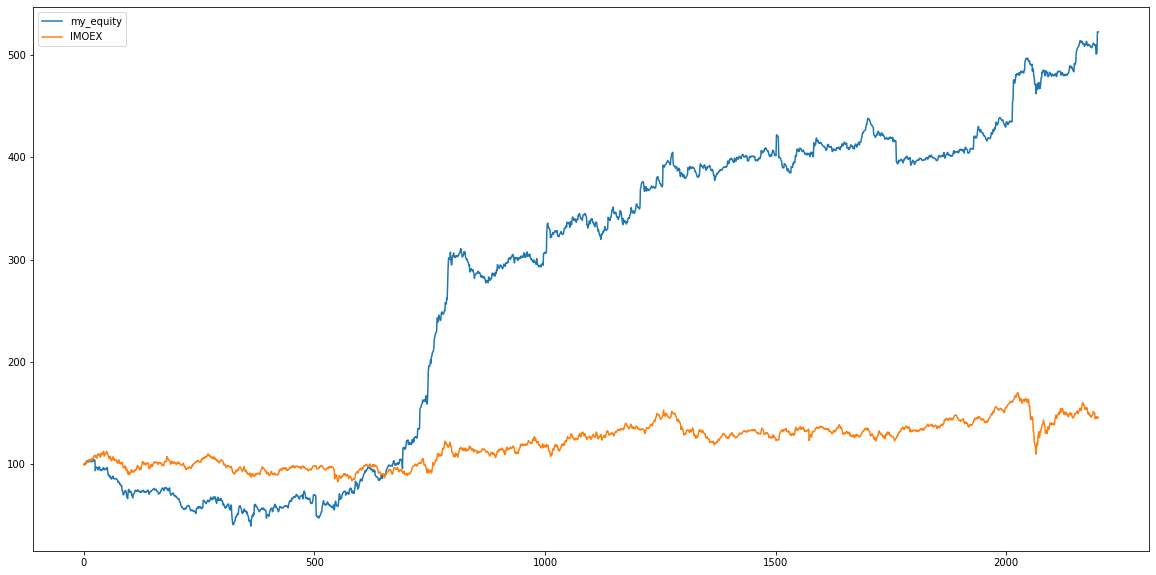

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(for_plot['equity'], label='my_equity')
plt.plot(for_plot['<CLOSE>']/33.18, label='IMOEX')
plt.legend()
plt.show()